***Exercise 1, Question C***



In this question, we are asked to train each one of the models of 1B, for 3 epochs, on the same data set. Then, for each layer of our models, we compute the maximum value of the gradient on a given mini-batch (in our case te 1st batch).

Moreover for each ANN depth, we create a plot of “layer depth vs. max gradient", and organize them as a grid, so that the results for the different activation functions for each depth choice appear on the same subplot. 


***Global Imports***

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.manifold import SpectralEmbedding
from keras import backend as K

from tensorflow.keras.datasets import mnist

***Dataset load and preprocessing***

In order to calculate the gradients for each layer of our models (that is the gradient of the loss function with respect to the weights, for each layer), we need to perform the gradient descent algorithm 'manually'. 


So, appart from the usual preprocessing of our dataset, we also split our training set into batches of 64 samples each.

In [ ]:
# Load the MNIST data set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)


#normalize the image data to the interval [0, 1]. This is done by dividing by 255.
x_train = x_train / 255.0
x_test = x_test / 255.0


#create one-hot vectors for each label in the data set
label_set = np.sort(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, len(label_set))
y_test = keras.utils.to_categorical(y_test, len(label_set))


x_train = x_train.reshape(len(x_train), 28 * 28)
x_test = x_test.reshape(len(x_test), 28 * 28)

# split training set into batches of 64 samples
dataset = tf.data.Dataset.from_tensor_slices((x_train.reshape(60000, 784).astype("float32"), y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

(60000, 28, 28)
(10000, 28, 28)


***Model_1a***

Method tape.gradient() returns for each layer $[l]$, 2 matrices of shapes $(n_{[l-1]}$ x $n_{[l]})$ and $(n_{[l]}$ x 1) respectively. 


The first matrix is the gradient of the loss function with respect to matrix w:  $\frac{\partial E}{\partial w^{[l]}}$, and the second is the gradient of the loss function with respect to matrix b:  $\frac{\partial E}{\partial b^{[l]}}$, for layer $[l]$. $n_{[l]}$ is the number of nodes in layer $[l]$. 

For our plots, we are using the matrices that correspond to the gradients wrt w, as they usually contain larger values than those of the matrices that correspond to the gradients wrt b. Moreover, in order to somehow compare those matrices and find the max gradient as asked, we are calculating the mean of the elements of each one of them, and we are using those means instead.

In [ ]:
#define model
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="relu")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="relu")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="relu")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="relu")
l4 = layer4(l3)
layer5 = keras.layers.Dense(10, activation="softmax")
l5 = layer5(l4)

model1a = tf.keras.Model(inputs, l5)

optimizer=keras.optimizers.SGD(learning_rate=0.01)

# For each epoch, we are going to keep here the gradients and the values for each layer
layers_1a = [layer1, layer2, layer3, layer4, layer5]
layers_gradients_1a = [[] for i in range(len(layers_1a))]

In [ ]:
def training_loop(model, layers, layers_gradients):

  # implement the gradient descent algorithm for 3 epochs
  for i in range(3):  
    for step, (x, y) in enumerate(dataset):

        # Open a GradientTape.
        with tf.GradientTape(persistent=True) as tape:

            # Loss value for this batch.
            loss = tf.keras.losses.CategoricalCrossentropy()(y, model(x))

        
        # Get gradients of the loss wrt the weights.
        gradients = [[] for i in range(len(layers))]
        
       
        for i in range(len(layers)):
          gradients[i] = tape.gradient(loss, layers[i].trainable_weights)
          
        # keep gradients for the 1st batch
        if step == 63:
          for i in range(len(layers_gradients)):
            layers_gradients[i].append(gradients[i])
      

        # Update the weights of our layers.

        for i in range(len(layers)):
          optimizer.apply_gradients(zip(gradients[i], layers[i].trainable_weights))
       

        # Logging.
        if step % 100 == 0:
            print("Step:", step, "Loss:", float(loss))

  return layers_gradients


In [ ]:
def evaluate(layers_gradients):
  
  max_gradients = []

  for layer_gradient in layers_gradients:
    #layer, epoch_1
    layer_w_e1, layer_b_e1 = layer_gradient[0]
    #layer, epoch_2
    layer_w_e2, layer_b_e2 = layer_gradient[1]
    #layer, epoch_3
    layer_w_e3, layer_b_e3 = layer_gradient[2]

    maxl_w = max(np.array(layer_w_e1).mean(),np.array(layer_w_e2).mean(),np.array(layer_w_e3).mean())
    print(maxl_w)
    maxl_b = max(np.array(layer_b_e1).mean(),np.array(layer_b_e2).mean(),np.array(layer_b_e3).mean())
    print(maxl_b)

    max_gradients.append(maxl_w)
  return max_gradients

In [ ]:
layers_gradients_1a = training_loop(model1a, layers_1a, layers_gradients_1a)

Step: 0 Loss: 2.3142075538635254
Step: 100 Loss: 2.223457098007202
Step: 200 Loss: 2.085066795349121
Step: 300 Loss: 1.8194823265075684
Step: 400 Loss: 1.5773816108703613
Step: 500 Loss: 1.1951351165771484
Step: 600 Loss: 1.1511472463607788
Step: 700 Loss: 1.0788182020187378
Step: 800 Loss: 0.5909669399261475
Step: 900 Loss: 0.43375223875045776
Step: 0 Loss: 0.5819963216781616
Step: 100 Loss: 0.7537761926651001
Step: 200 Loss: 0.6733541488647461
Step: 300 Loss: 0.3247784376144409
Step: 400 Loss: 0.31984296441078186
Step: 500 Loss: 0.3236030638217926
Step: 600 Loss: 0.3571191430091858
Step: 700 Loss: 0.36812782287597656
Step: 800 Loss: 0.3830130100250244
Step: 900 Loss: 0.33637547492980957
Step: 0 Loss: 0.34683388471603394
Step: 100 Loss: 0.3273448050022125
Step: 200 Loss: 0.403767466545105
Step: 300 Loss: 0.38782399892807007
Step: 400 Loss: 0.2222292423248291
Step: 500 Loss: 0.36528974771499634
Step: 600 Loss: 0.2847553491592407
Step: 700 Loss: 0.26498591899871826
Step: 800 Loss: 0.310

In [ ]:
m1a = evaluate(layers_gradients_1a)

0.000288352
0.0013706322
-0.00017082883
-0.0009936563
0.0019753696
0.0014212871
0.0025001192
0.0009985325
-2.3283065e-11
2.7939678e-10


***Model_1b***

In [ ]:
# define model 
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="tanh")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="tanh")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="tanh")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="tanh")
l4 = layer4(l3)
layer5 = keras.layers.Dense(10, activation="softmax")
l5 = layer5(l4)

model1b = tf.keras.Model(inputs, l5)

optimizer=keras.optimizers.SGD(learning_rate=0.01)


# For each epoch, we are going to keep here the gradients and the values for each layer

layers_1b = [layer1, layer2, layer3, layer4, layer5]
layers_gradients_1b = [[] for i in range(len(layers_1b))]

In [ ]:
layers_gradients_1b = training_loop(model1b, layers_1b, layers_gradients_1b)

Step: 0 Loss: 2.269225597381592
Step: 100 Loss: 1.684699535369873
Step: 200 Loss: 1.3466739654541016
Step: 300 Loss: 1.1478924751281738
Step: 400 Loss: 0.967097282409668
Step: 500 Loss: 1.0111382007598877
Step: 600 Loss: 0.696932315826416
Step: 700 Loss: 0.6835916042327881
Step: 800 Loss: 0.6838964223861694
Step: 900 Loss: 0.37721744179725647
Step: 0 Loss: 0.4419541358947754
Step: 100 Loss: 0.5565916299819946
Step: 200 Loss: 0.6718469858169556
Step: 300 Loss: 0.4586685299873352
Step: 400 Loss: 0.3733883500099182
Step: 500 Loss: 0.59538733959198
Step: 600 Loss: 0.39343079924583435
Step: 700 Loss: 0.4407988488674164
Step: 800 Loss: 0.5005797147750854
Step: 900 Loss: 0.38430142402648926
Step: 0 Loss: 0.32700324058532715
Step: 100 Loss: 0.34848636388778687
Step: 200 Loss: 0.38346025347709656
Step: 300 Loss: 0.32854580879211426
Step: 400 Loss: 0.4184722900390625
Step: 500 Loss: 0.3197658061981201
Step: 600 Loss: 0.5178813338279724
Step: 700 Loss: 0.46363043785095215
Step: 800 Loss: 0.411672

In [ ]:
m1b = evaluate(layers_gradients_1b)

0.0013907469
0.011317524
0.00048357755
0.0043494413
0.00022662124
0.002467068
0.00027104656
0.0043242173
1.7462298e-10
9.313226e-10


***Model_1c***

In [ ]:
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="sigmoid")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="sigmoid")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="sigmoid")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="sigmoid")
l4 = layer4(l3)
layer5 = keras.layers.Dense(10, activation="softmax")
l5 = layer5(l4)

model1c = tf.keras.Model(inputs, l5)

optimizer=keras.optimizers.SGD(learning_rate=0.01)



# For each epoch, we are going to keep here the gradients and the values for each layer
layers_1c = [layer1, layer2, layer3, layer4, layer5]
layers_gradients_1c = [[] for i in range(len(layers_1c))]

In [ ]:
layers_gradients_1c = training_loop(model1c, layers_1c, layers_gradients_1c)

Step: 0 Loss: 2.412320852279663
Step: 100 Loss: 2.3968327045440674
Step: 200 Loss: 2.3132338523864746
Step: 300 Loss: 2.3080930709838867
Step: 400 Loss: 2.295645236968994
Step: 500 Loss: 2.2912678718566895
Step: 600 Loss: 2.3090620040893555
Step: 700 Loss: 2.292809009552002
Step: 800 Loss: 2.2881524562835693
Step: 900 Loss: 2.3022797107696533
Step: 0 Loss: 2.2991385459899902
Step: 100 Loss: 2.2999258041381836
Step: 200 Loss: 2.2925827503204346
Step: 300 Loss: 2.3032050132751465
Step: 400 Loss: 2.2830724716186523
Step: 500 Loss: 2.302395820617676
Step: 600 Loss: 2.308917284011841
Step: 700 Loss: 2.3064122200012207
Step: 800 Loss: 2.3041787147521973
Step: 900 Loss: 2.291598320007324
Step: 0 Loss: 2.3078129291534424
Step: 100 Loss: 2.3016672134399414
Step: 200 Loss: 2.311156988143921
Step: 300 Loss: 2.3146843910217285
Step: 400 Loss: 2.293673515319824
Step: 500 Loss: 2.292630910873413
Step: 600 Loss: 2.3001561164855957
Step: 700 Loss: 2.308253288269043
Step: 800 Loss: 2.294635772705078
St

In [ ]:
m1c = evaluate(layers_gradients_1c)

1.1949172e-06
2.168795e-06
2.4631123e-05
4.8785005e-05
5.16601e-05
9.303211e-05
0.00058754743
0.0011352673
6.4028427e-10
1.0244549e-09


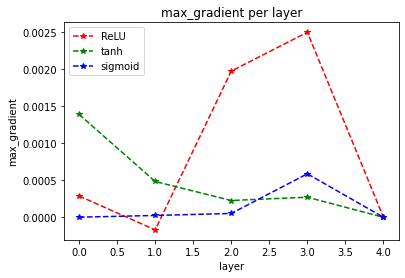

In [ ]:
l = [0, 1, 2, 3, 4]
  
plt.plot(l, m1a, '*--', color='r', label='ReLU')
plt.plot(l, m1b, '*--', color='g', label='tanh')
plt.plot(l, m1c, '*--', color='b', label='sigmoid')

plt.ylabel("max_gradient")
plt.xlabel("layer")
plt.title("max_gradient per layer")
  
plt.legend()
  
plt.show()

***Observations***


From the graph above, we can observe that in general, the values of the gradient wrt w, vary in the cases of the tanh and the ReLU activation functions. 

In the case of the sigmoid activation however, the value of the gradient is almost zero for all layers. Respectivelly, in the previous question, we had observed that it took too many epochs for model 1c to reach to a descent accuracy, comparing to the results of models 1a and 1b, where the training process was much faster.

This is known as the vanishing gradient problem and is caused by the use of the sigmoid as an activation function for the hidden layers.
In the case of shallow networks with only a few layers, like ours, this isn’t a very big problem, as training is just slowed down. However, in the case of much deeper architectures, as we have in ii) and iii), it can cause the gradient to be too small that the whole training process freezes.

The reason for this happening is because the output of the sigmoid function saturates (becomes parallel to x-axis) for the most part of the curve. Thus, its gradient at these regions is almost zero. 

Now we know that the backpropagation algorithm calculates the derivatives for  each layer, starting from the output and moving towards the input layer of our model. 

For a layer, this derivative depends on the products of the derivatives of the activation fuctions of all its previous layers. So, when n hidden layers use an activation like the sigmoid function, n small derivatives are multiplied together. Thus, the gradient decreases exponentially as we propagate down to the initial layers. This can also be observed in the graph above, as in the case of the sigmoid activation, the value of the gradient tends to become smaller as we move backwards in the network.


We know that: $δw^{[l]} = -ε \frac{\partial E}{\partial w^{[l]}}$, which means that when the gradients values are close to 0 for a layer, the weight update on this layer is also very small, and this slows down the learning process (or even freezes it). 



In general, the tanh activation function is also linked with the  vanishing gradients problem:

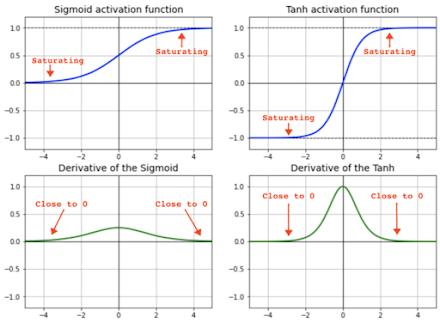

However, the gradient of tanh is four times greater than the gradient of the sigmoid function, and this results in higher values of the gradient during training, and thus higher updates in the weights of the network as well. Moreover, the output of tanh is symmetric around zero, leading to faster convergence. 


This is probably the reason why we didn't face any problems with the training of our models which use the tanh as an activation for the hidden layers.

 




***Model_2a***

In [ ]:
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="relu")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="relu")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="relu")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="relu")
l4 = layer4(l3)
layer5 = keras.layers.Dense(32, activation="relu")
l5 = layer5(l4)
layer6 = keras.layers.Dense(32, activation="relu")
l6 = layer6(l5)
layer7 = keras.layers.Dense(32, activation="relu")
l7 = layer7(l6)
layer8 = keras.layers.Dense(32, activation="relu")
l8 = layer8(l7)
layer9 = keras.layers.Dense(32, activation="relu")
l9 = layer9(l8)
layer10 = keras.layers.Dense(32, activation="relu")
l10 = layer10(l9)
layer11 = keras.layers.Dense(32, activation="relu")
l11 = layer11(l10)
layer12 = keras.layers.Dense(32, activation="relu")
l12 = layer12(l11)
layer13 = keras.layers.Dense(32, activation="relu")
l13 = layer13(l12)
layer14 = keras.layers.Dense(32, activation="relu")
l14 = layer14(l13)
layer15 = keras.layers.Dense(32, activation="relu")
l15 = layer15(l14)
layer16 = keras.layers.Dense(32, activation="relu")
l16 = layer16(l15)
layer17 = keras.layers.Dense(32, activation="relu")
l17 = layer17(l16)
layer18 = keras.layers.Dense(32, activation="relu")
l18 = layer18(l17)
layer19 = keras.layers.Dense(32, activation="relu")
l19 = layer19(l18)
layer20 = keras.layers.Dense(10, activation="softmax")
l20 = layer20(l19)

model2a = tf.keras.Model(inputs, l20)

optimizer=keras.optimizers.SGD(learning_rate=0.01)


# For each epoch, we are going to keep here the gradients and the values for each layer
layers_2a = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, 
             layer11, layer12, layer13, layer14, layer15, layer16, layer17, layer18, layer19, layer20]
layers_gradients_2a = [[] for i in range(len(layers_2a))]

In [ ]:
layers_gradients_2a = training_loop(model2a, layers_2a, layers_gradients_2a)

Step: 0 Loss: 2.302600860595703
Step: 100 Loss: 2.299833297729492
Step: 200 Loss: 2.2984068393707275
Step: 300 Loss: 2.295334577560425
Step: 400 Loss: 2.2983951568603516
Step: 500 Loss: 2.2931265830993652
Step: 600 Loss: 2.286267042160034
Step: 700 Loss: 2.2841625213623047
Step: 800 Loss: 2.2793025970458984
Step: 900 Loss: 2.2651541233062744
Step: 0 Loss: 2.2687172889709473
Step: 100 Loss: 2.2539496421813965
Step: 200 Loss: 2.2085049152374268
Step: 300 Loss: 2.1328601837158203
Step: 400 Loss: 2.0211873054504395
Step: 500 Loss: 1.9656133651733398
Step: 600 Loss: 1.85891592502594
Step: 700 Loss: 1.8758708238601685
Step: 800 Loss: 1.760880470275879
Step: 900 Loss: 1.710737943649292
Step: 0 Loss: 1.6087281703948975
Step: 100 Loss: 1.6523501873016357
Step: 200 Loss: 1.5956676006317139
Step: 300 Loss: 1.7020601034164429
Step: 400 Loss: 1.4949090480804443
Step: 500 Loss: 1.5925045013427734
Step: 600 Loss: 1.4741398096084595
Step: 700 Loss: 1.7016775608062744
Step: 800 Loss: 1.4500436782836914

In [ ]:
m2a = evaluate(layers_gradients_2a)

0.0006153083
0.0058260662
0.00012137616
0.000100178644
0.0009605271
0.006972851
0.00014394242
0.00026557548
0.00044994237
0.0040994994
0.00036353504
0.0068013268
0.0016164094
0.026211761
0.00056981144
0.012304806
0.0004290153
0.007891103
0.00034914102
0.008049096
0.00012049767
0.0036308877
2.4146726e-07
0.00033825485
0.00014376204
0.0019641402
-2.5031193e-07
0.00030610105
-5.442039e-07
-0.0008307813
2.0350592e-07
0.00044684566
-4.0096467e-07
0.00012622622
1.3983176e-06
0.0020853942
1.5191913e-06
0.0019076396
5.820766e-10
0.0


***Model_2b***

In [ ]:
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="tanh")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="tanh")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="tanh")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="tanh")
l4 = layer4(l3)
layer5 = keras.layers.Dense(32, activation="tanh")
l5 = layer5(l4)
layer6 = keras.layers.Dense(32, activation="tanh")
l6 = layer6(l5)
layer7 = keras.layers.Dense(32, activation="tanh")
l7 = layer7(l6)
layer8 = keras.layers.Dense(32, activation="tanh")
l8 = layer8(l7)
layer9 = keras.layers.Dense(32, activation="tanh")
l9 = layer9(l8)
layer10 = keras.layers.Dense(32, activation="tanh")
l10 = layer10(l9)
layer11 = keras.layers.Dense(32, activation="tanh")
l11 = layer11(l10)
layer12 = keras.layers.Dense(32, activation="tanh")
l12 = layer12(l11)
layer13 = keras.layers.Dense(32, activation="tanh")
l13 = layer13(l12)
layer14 = keras.layers.Dense(32, activation="tanh")
l14 = layer14(l13)
layer15 = keras.layers.Dense(32, activation="tanh")
l15 = layer15(l14)
layer16 = keras.layers.Dense(32, activation="tanh")
l16 = layer16(l15)
layer17 = keras.layers.Dense(32, activation="tanh")
l17 = layer17(l16)
layer18 = keras.layers.Dense(32, activation="tanh")
l18 = layer18(l17)
layer19 = keras.layers.Dense(32, activation="tanh")
l19 = layer19(l18)
layer20 = keras.layers.Dense(10, activation="softmax")
l20 = layer20(l19)

model2b = tf.keras.Model(inputs, l20)

optimizer=keras.optimizers.SGD(learning_rate=0.01)


# For each epoch, we are going to keep here the gradients and the values for each layer
layers_2b = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, 
             layer11, layer12, layer13, layer14, layer15, layer16, layer17, layer18, layer19, layer20]
layers_gradients_2b = [[] for i in range(len(layers_2b))]

In [ ]:
layers_gradients_2b = training_loop(model2b, layers_2b, layers_gradients_2b)

Step: 0 Loss: 2.303190231323242
Step: 100 Loss: 1.8645453453063965
Step: 200 Loss: 1.563291072845459
Step: 300 Loss: 1.3060665130615234
Step: 400 Loss: 1.0167605876922607
Step: 500 Loss: 0.9301596879959106
Step: 600 Loss: 0.7169268131256104
Step: 700 Loss: 0.6849828958511353
Step: 800 Loss: 0.725782036781311
Step: 900 Loss: 0.43052294850349426
Step: 0 Loss: 0.4592685401439667
Step: 100 Loss: 0.5502049326896667
Step: 200 Loss: 0.5066417455673218
Step: 300 Loss: 0.5328242778778076
Step: 400 Loss: 0.5138838887214661
Step: 500 Loss: 0.3807033896446228
Step: 600 Loss: 0.6204630732536316
Step: 700 Loss: 0.447238564491272
Step: 800 Loss: 0.3992851972579956
Step: 900 Loss: 0.319091260433197
Step: 0 Loss: 0.641578197479248
Step: 100 Loss: 0.5150370597839355
Step: 200 Loss: 0.3957214951515198
Step: 300 Loss: 0.3394984006881714
Step: 400 Loss: 0.32362765073776245
Step: 500 Loss: 0.3179941475391388
Step: 600 Loss: 0.35517019033432007
Step: 700 Loss: 0.3276292085647583
Step: 800 Loss: 0.14909382164

In [ ]:
m2b = evaluate(layers_gradients_2b)

0.0020895365
0.020712674
0.0018765873
-0.0004888582
0.0004645742
0.0019162982
0.00019568973
0.006518472
-1.7562923e-05
0.003644426
0.00071616436
0.00870156
0.00037089514
0.016847853
9.167471e-05
0.0063825687
0.00019889057
-0.00060442055
0.0005932736
0.004644464
0.00022151828
0.003510653
0.000108016095
0.003997183
4.5197405e-05
0.0022381807
0.00025572797
0.0030594065
0.00012635208
0.009122055
-6.398134e-05
0.002865517
6.808762e-05
0.002656607
-0.00016155574
0.008950738
0.00055190723
0.0017741619
2.7648639e-11
0.0


***Model_2c***

In [ ]:
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="sigmoid")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="sigmoid")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="sigmoid")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="sigmoid")
l4 = layer4(l3)
layer5 = keras.layers.Dense(32, activation="sigmoid")
l5 = layer5(l4)
layer6 = keras.layers.Dense(32, activation="sigmoid")
l6 = layer6(l5)
layer7 = keras.layers.Dense(32, activation="sigmoid")
l7 = layer7(l6)
layer8 = keras.layers.Dense(32, activation="sigmoid")
l8 = layer8(l7)
layer9 = keras.layers.Dense(32, activation="sigmoid")
l9 = layer9(l8)
layer10 = keras.layers.Dense(32, activation="sigmoid")
l10 = layer10(l9)
layer11 = keras.layers.Dense(32, activation="sigmoid")
l11 = layer11(l10)
layer12 = keras.layers.Dense(32, activation="sigmoid")
l12 = layer12(l11)
layer13 = keras.layers.Dense(32, activation="sigmoid")
l13 = layer13(l12)
layer14 = keras.layers.Dense(32, activation="sigmoid")
l14 = layer14(l13)
layer15 = keras.layers.Dense(32, activation="sigmoid")
l15 = layer15(l14)
layer16 = keras.layers.Dense(32, activation="sigmoid")
l16 = layer16(l15)
layer17 = keras.layers.Dense(32, activation="sigmoid")
l17 = layer17(l16)
layer18 = keras.layers.Dense(32, activation="sigmoid")
l18 = layer18(l17)
layer19 = keras.layers.Dense(32, activation="sigmoid")
l19 = layer19(l18)
layer20 = keras.layers.Dense(10, activation="softmax")
l20 = layer20(l19)

model2c = tf.keras.Model(inputs, l20)

optimizer=keras.optimizers.SGD(learning_rate=0.01)

# For each epoch, we are going to keep here the gradients and the values for each layer
layers_2c = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, 
             layer11, layer12, layer13, layer14, layer15, layer16, layer17, layer18, layer19, layer20]
layers_gradients_2c = [[] for i in range(len(layers_2c))]

In [ ]:
layers_gradients_2c = training_loop(model2c, layers_2c, layers_gradients_2c)

Step: 0 Loss: 2.3312995433807373
Step: 100 Loss: 2.3107075691223145
Step: 200 Loss: 2.2930908203125
Step: 300 Loss: 2.3054025173187256
Step: 400 Loss: 2.3041248321533203
Step: 500 Loss: 2.3005905151367188
Step: 600 Loss: 2.29660701751709
Step: 700 Loss: 2.295224189758301
Step: 800 Loss: 2.3054702281951904
Step: 900 Loss: 2.293970823287964
Step: 0 Loss: 2.303091526031494
Step: 100 Loss: 2.293977737426758
Step: 200 Loss: 2.313600540161133
Step: 300 Loss: 2.2974143028259277
Step: 400 Loss: 2.3030409812927246
Step: 500 Loss: 2.303351879119873
Step: 600 Loss: 2.3146955966949463
Step: 700 Loss: 2.2893385887145996
Step: 800 Loss: 2.3189897537231445
Step: 900 Loss: 2.294959545135498
Step: 0 Loss: 2.2954893112182617
Step: 100 Loss: 2.3005645275115967
Step: 200 Loss: 2.297531843185425
Step: 300 Loss: 2.301835536956787
Step: 400 Loss: 2.292410373687744
Step: 500 Loss: 2.285243272781372
Step: 600 Loss: 2.3109140396118164
Step: 700 Loss: 2.294724464416504
Step: 800 Loss: 2.300786018371582
Step: 900

In [ ]:
m2c = evaluate(layers_gradients_2c)

7.508775e-16
5.4711035e-15
7.796636e-15
1.6857831e-14
5.7651133e-15
1.1232497e-14
1.4229454e-13
2.7904973e-13
-1.7013387e-13
-3.2555577e-13
8.003832e-13
1.6579342e-12
1.959908e-11
3.8429714e-11
1.3480064e-11
2.7436602e-11
3.9021876e-11
7.692863e-11
1.8603921e-09
3.6766648e-09
5.0751847e-09
1.0010098e-08
4.3491113e-08
9.3665626e-08
1.4228266e-07
2.8933107e-07
3.2457976e-07
6.722295e-07
3.0849935e-06
6.375411e-06
-2.5267404e-06
-4.986465e-06
-1.3949135e-05
-2.787702e-05
0.00015301458
0.0003019533
0.00031410108
0.00058353913
-1.8626452e-10
1.1175871e-09


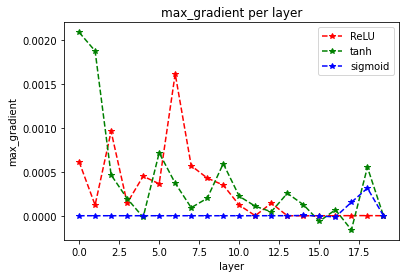

In [ ]:
l = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  
plt.plot(l, m2a, '*--', color='r', label='ReLU')
plt.plot(l, m2b, '*--', color='g', label='tanh')
plt.plot(l, m2c, '*--', color='b', label='sigmoid')

plt.ylabel("max_gradient")
plt.xlabel("layer")
plt.title("max_gradient per layer")
  
plt.legend()
  
plt.show()

***Observations***


Once again we observe that the values of the gradient wrt w, vary in the cases of the tanh and the ReLU activation functions, while in the case of the sigmoid, they are close to zero in all layers of our models. 

Indeed, if we go back in question 1B, we will see that both models 2a and 2b manage to achieve descent accuracy scores within small numbers of iterations of the training algorithm, while the training process of model 2c did not proceed at all. This is due to the vanishing gradient problem we discussed above, which causes the gradients of the input layers to be so small that the training process freezes. This is also depicted in the graph above, where the only non zero values of the gradients for the sigmoid function are observed very close to the output layer.  

***Model_3a***

In [ ]:
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="relu")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="relu")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="relu")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="relu")
l4 = layer4(l3)
layer5 = keras.layers.Dense(32, activation="relu")
l5 = layer5(l4)
layer6 = keras.layers.Dense(32, activation="relu")
l6 = layer6(l5)
layer7 = keras.layers.Dense(32, activation="relu")
l7 = layer7(l6)
layer8 = keras.layers.Dense(32, activation="relu")
l8 = layer8(l7)
layer9 = keras.layers.Dense(32, activation="relu")
l9 = layer9(l8)
layer10 = keras.layers.Dense(32, activation="relu")
l10 = layer10(l9)
layer11 = keras.layers.Dense(32, activation="relu")
l11 = layer11(l10)
layer12 = keras.layers.Dense(32, activation="relu")
l12 = layer12(l11)
layer13 = keras.layers.Dense(32, activation="relu")
l13 = layer13(l12)
layer14 = keras.layers.Dense(32, activation="relu")
l14 = layer14(l13)
layer15 = keras.layers.Dense(32, activation="relu")
l15 = layer15(l14)
layer16 = keras.layers.Dense(32, activation="relu")
l16 = layer16(l15)
layer17 = keras.layers.Dense(32, activation="relu")
l17 = layer17(l16)
layer18 = keras.layers.Dense(32, activation="relu")
l18 = layer18(l17)
layer19 = keras.layers.Dense(32, activation="relu")
l19 = layer19(l18)
layer20 = keras.layers.Dense(10, activation="relu")
l20 = layer20(l19)
layer21 = keras.layers.Dense(32, activation="relu")
l21 = layer21(l20)
layer22 = keras.layers.Dense(32, activation="relu")
l22 = layer22(l21)
layer23 = keras.layers.Dense(32, activation="relu")
l23 = layer23(l22)
layer24 = keras.layers.Dense(32, activation="relu")
l24 = layer24(l23)
layer25 = keras.layers.Dense(32, activation="relu")
l25 = layer25(l24)
layer26 = keras.layers.Dense(32, activation="relu")
l26 = layer26(l25)
layer27 = keras.layers.Dense(32, activation="relu")
l27 = layer27(l26)
layer28 = keras.layers.Dense(32, activation="relu")
l28 = layer28(l27)
layer29 = keras.layers.Dense(32, activation="relu")
l29 = layer29(l28)
layer30 = keras.layers.Dense(32, activation="relu")
l30 = layer30(l29)
layer31 = keras.layers.Dense(32, activation="relu")
l31 = layer31(l30)
layer32 = keras.layers.Dense(32, activation="relu")
l32 = layer32(l31)
layer33 = keras.layers.Dense(32, activation="relu")
l33 = layer33(l32)
layer34 = keras.layers.Dense(32, activation="relu")
l34 = layer34(l33)
layer35 = keras.layers.Dense(32, activation="relu")
l35 = layer35(l34)
layer36 = keras.layers.Dense(32, activation="relu")
l36 = layer36(l35)
layer37 = keras.layers.Dense(32, activation="relu")
l37 = layer37(l36)
layer38 = keras.layers.Dense(32, activation="relu")
l38 = layer38(l37)
layer39 = keras.layers.Dense(32, activation="relu")
l39 = layer39(l38)
layer40 = keras.layers.Dense(10, activation="softmax")
l40 = layer40(l39)


model3a = tf.keras.Model(inputs, l40)

optimizer=keras.optimizers.SGD(learning_rate=0.01)

# For each epoch, we are going to keep here the gradients and the values for each layer
layers_3a = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, 
             layer11, layer12, layer13, layer14, layer15, layer16, layer17, layer18, layer19, layer20,
             layer21, layer22, layer23, layer24, layer25, layer26, layer27, layer28, layer29, layer30, 
             layer31, layer32, layer33, layer34, layer35, layer36, layer37, layer38, layer39, layer40]
layers_gradients_3a = [[] for i in range(len(layers_3a))]

In [ ]:
layers_gradients_3a = training_loop(model3a, layers_3a, layers_gradients_3a)

Step: 0 Loss: 2.3025851249694824
Step: 100 Loss: 2.302241325378418
Step: 200 Loss: 2.3042850494384766
Step: 300 Loss: 2.304769992828369
Step: 400 Loss: 2.2983601093292236
Step: 500 Loss: 2.3043339252471924
Step: 600 Loss: 2.303903102874756
Step: 700 Loss: 2.30332612991333
Step: 800 Loss: 2.3007116317749023
Step: 900 Loss: 2.2945802211761475
Step: 0 Loss: 2.3008246421813965
Step: 100 Loss: 2.300325393676758
Step: 200 Loss: 2.2882461547851562
Step: 300 Loss: 2.305640697479248
Step: 400 Loss: 2.3048598766326904
Step: 500 Loss: 2.3006792068481445
Step: 600 Loss: 2.3037290573120117
Step: 700 Loss: 2.3035173416137695
Step: 800 Loss: 2.292301654815674
Step: 900 Loss: 2.299982786178589
Step: 0 Loss: 2.3045690059661865
Step: 100 Loss: 2.2957112789154053
Step: 200 Loss: 2.303709030151367
Step: 300 Loss: 2.3091201782226562
Step: 400 Loss: 2.3112053871154785
Step: 500 Loss: 2.3051700592041016
Step: 600 Loss: 2.3094570636749268
Step: 700 Loss: 2.3047001361846924
Step: 800 Loss: 2.2942237854003906
S

In [ ]:
m3a = evaluate(layers_gradients_3a)

3.6662617e-11
8.2595375e-10
3.4575273e-10
1.996962e-09
2.2677257e-10
2.036838e-09
4.1363424e-10
4.6706194e-09
4.547253e-10
8.68393e-09
7.7526735e-11
1.3423156e-09
3.1198003e-10
1.1084801e-08
4.8634535e-10
2.7849484e-08
2.4050667e-10
2.6274652e-08
3.1199082e-10
7.886133e-08
1.5126285e-10
4.3046956e-08
2.3843755e-10
1.13397135e-07
2.725144e-10
1.471699e-07
1.9785076e-10
1.1999782e-07
2.0804972e-10
1.1583491e-07
2.5512525e-10
1.2059985e-07
2.4206503e-10
2.3142866e-07
4.9757004e-10
4.1225445e-07
1.06031864e-10
1.094913e-07
7.6982587e-10
2.3793368e-06
4.0873652e-10
2.405895e-06
2.1985268e-10
2.2220704e-06
1.9467414e-10
2.7393505e-06
2.5591082e-10
4.076659e-06
3.338967e-10
7.827295e-06
4.9693727e-10
1.2938599e-05
3.9729947e-10
1.2271061e-05
5.3595944e-10
1.6334121e-05
4.7064375e-10
1.4459575e-05
9.796638e-10
3.185642e-05
1.4042107e-09
3.5280344e-05
4.840599e-09
6.474527e-05
1.1923227e-08
0.00010366468
4.444523e-08
0.00016342642
9.878255e-08
0.00026407058
1.4014975e-06
0.002162904
8.647879e-0

***Model_3b***

In [ ]:
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="tanh")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="tanh")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="tanh")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="tanh")
l4 = layer4(l3)
layer5 = keras.layers.Dense(32, activation="tanh")
l5 = layer5(l4)
layer6 = keras.layers.Dense(32, activation="tanh")
l6 = layer6(l5)
layer7 = keras.layers.Dense(32, activation="tanh")
l7 = layer7(l6)
layer8 = keras.layers.Dense(32, activation="tanh")
l8 = layer8(l7)
layer9 = keras.layers.Dense(32, activation="tanh")
l9 = layer9(l8)
layer10 = keras.layers.Dense(32, activation="tanh")
l10 = layer10(l9)
layer11 = keras.layers.Dense(32, activation="tanh")
l11 = layer11(l10)
layer12 = keras.layers.Dense(32, activation="tanh")
l12 = layer12(l11)
layer13 = keras.layers.Dense(32, activation="tanh")
l13 = layer13(l12)
layer14 = keras.layers.Dense(32, activation="tanh")
l14 = layer14(l13)
layer15 = keras.layers.Dense(32, activation="tanh")
l15 = layer15(l14)
layer16 = keras.layers.Dense(32, activation="tanh")
l16 = layer16(l15)
layer17 = keras.layers.Dense(32, activation="tanh")
l17 = layer17(l16)
layer18 = keras.layers.Dense(32, activation="tanh")
l18 = layer18(l17)
layer19 = keras.layers.Dense(32, activation="tanh")
l19 = layer19(l18)
layer20 = keras.layers.Dense(10, activation="tanh")
l20 = layer20(l19)
layer21 = keras.layers.Dense(32, activation="tanh")
l21 = layer21(l20)
layer22 = keras.layers.Dense(32, activation="tanh")
l22 = layer22(l21)
layer23 = keras.layers.Dense(32, activation="tanh")
l23 = layer23(l22)
layer24 = keras.layers.Dense(32, activation="tanh")
l24 = layer24(l23)
layer25 = keras.layers.Dense(32, activation="tanh")
l25 = layer25(l24)
layer26 = keras.layers.Dense(32, activation="tanh")
l26 = layer26(l25)
layer27 = keras.layers.Dense(32, activation="tanh")
l27 = layer27(l26)
layer28 = keras.layers.Dense(32, activation="tanh")
l28 = layer28(l27)
layer29 = keras.layers.Dense(32, activation="tanh")
l29 = layer29(l28)
layer30 = keras.layers.Dense(32, activation="tanh")
l30 = layer30(l29)
layer31 = keras.layers.Dense(32, activation="tanh")
l31 = layer31(l30)
layer32 = keras.layers.Dense(32, activation="tanh")
l32 = layer32(l31)
layer33 = keras.layers.Dense(32, activation="tanh")
l33 = layer33(l32)
layer34 = keras.layers.Dense(32, activation="tanh")
l34 = layer34(l33)
layer35 = keras.layers.Dense(32, activation="tanh")
l35 = layer35(l34)
layer36 = keras.layers.Dense(32, activation="tanh")
l36 = layer36(l35)
layer37 = keras.layers.Dense(32, activation="tanh")
l37 = layer37(l36)
layer38 = keras.layers.Dense(32, activation="tanh")
l38 = layer38(l37)
layer39 = keras.layers.Dense(32, activation="tanh")
l39 = layer39(l38)
layer40 = keras.layers.Dense(10, activation="softmax")
l40 = layer40(l39)


model3b = tf.keras.Model(inputs, l40)

optimizer=keras.optimizers.SGD(learning_rate=0.01)

# For each epoch, we are going to keep here the gradients and the values for each layer
layers_3b = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, 
             layer11, layer12, layer13, layer14, layer15, layer16, layer17, layer18, layer19, layer20,
             layer21, layer22, layer23, layer24, layer25, layer26, layer27, layer28, layer29, layer30, 
             layer31, layer32, layer33, layer34, layer35, layer36, layer37, layer38, layer39, layer40]
layers_gradients_3b = [[] for i in range(len(layers_3b))]

In [ ]:
layers_gradients_3b = training_loop(model3b, layers_3b, layers_gradients_3b)

Step: 0 Loss: 2.347759485244751
Step: 100 Loss: 2.153733730316162
Step: 200 Loss: 1.7176134586334229
Step: 300 Loss: 1.6339154243469238
Step: 400 Loss: 1.4866265058517456
Step: 500 Loss: 1.3990607261657715
Step: 600 Loss: 1.3153055906295776
Step: 700 Loss: 1.1855534315109253
Step: 800 Loss: 1.3139760494232178
Step: 900 Loss: 1.1983556747436523
Step: 0 Loss: 1.2198511362075806
Step: 100 Loss: 1.1207678318023682
Step: 200 Loss: 1.1370673179626465
Step: 300 Loss: 1.1401070356369019
Step: 400 Loss: 1.251177430152893
Step: 500 Loss: 1.023393154144287
Step: 600 Loss: 1.3100496530532837
Step: 700 Loss: 1.8788659572601318
Step: 800 Loss: 1.3253719806671143
Step: 900 Loss: 0.9194464683532715
Step: 0 Loss: 0.697556734085083
Step: 100 Loss: 0.9310704469680786
Step: 200 Loss: 0.7651653289794922
Step: 300 Loss: 1.0326266288757324
Step: 400 Loss: 0.9529677629470825
Step: 500 Loss: 1.077736496925354
Step: 600 Loss: 0.6822004318237305
Step: 700 Loss: 0.8778175711631775
Step: 800 Loss: 0.87388730049133

In [ ]:
m3b = evaluate(layers_gradients_3b)

0.002647532
0.01762852
8.059122e-05
0.010492777
0.002018807
0.012251124
0.0025037713
-0.00020956155
0.00087080617
-0.00030165585
0.0019461737
-0.0013863792
8.773961e-05
-0.00021284819
0.0017768837
0.032211334
6.159393e-05
0.0008182022
0.0042556943
-0.0031065107
5.3300377e-05
0.008705332
6.632734e-05
0.012037177
2.0285412e-05
0.0022343667
0.000990592
0.023447596
-1.745775e-05
0.03917686
0.0005153129
-0.0027182018
1.4931902e-05
-0.00082384504
3.67949e-05
0.024201907
-3.624158e-05
0.014782237
5.1525432e-05
0.0017283196
1.2636697e-05
-0.0026000754
-3.4657503e-05
0.015204918
0.00019211053
0.0013584485
5.6845336e-05
0.0013806305
0.00072846527
-0.001329513
0.0006610028
-0.00069973245
2.2319262e-05
0.00921525
0.00043247483
0.004713189
0.00012289424
0.009736535
0.001110128
0.0038040797
2.8574403e-05
0.0006444345
0.00011527083
0.0065386705
0.00040777886
0.0034422562
-2.848365e-05
0.009810368
1.2072327e-05
0.0026197447
7.5364915e-06
0.0020208808
0.00014942874
0.00114852
3.8961945e-05
-4.874592e-0

***Model_3c***

In [ ]:
inputs = tf.keras.Input(shape=(784,), dtype="float32")
layer1 = keras.layers.Dense(32, activation="sigmoid")
l1 = layer1(inputs)
layer2 = keras.layers.Dense(32, activation="sigmoid")
l2 = layer2(l1)
layer3 = keras.layers.Dense(32, activation="sigmoid")
l3 = layer3(l2)
layer4 = keras.layers.Dense(32, activation="sigmoid")
l4 = layer4(l3)
layer5 = keras.layers.Dense(32, activation="sigmoid")
l5 = layer5(l4)
layer6 = keras.layers.Dense(32, activation="sigmoid")
l6 = layer6(l5)
layer7 = keras.layers.Dense(32, activation="sigmoid")
l7 = layer7(l6)
layer8 = keras.layers.Dense(32, activation="sigmoid")
l8 = layer8(l7)
layer9 = keras.layers.Dense(32, activation="sigmoid")
l9 = layer9(l8)
layer10 = keras.layers.Dense(32, activation="sigmoid")
l10 = layer10(l9)
layer11 = keras.layers.Dense(32, activation="sigmoid")
l11 = layer11(l10)
layer12 = keras.layers.Dense(32, activation="sigmoid")
l12 = layer12(l11)
layer13 = keras.layers.Dense(32, activation="sigmoid")
l13 = layer13(l12)
layer14 = keras.layers.Dense(32, activation="sigmoid")
l14 = layer14(l13)
layer15 = keras.layers.Dense(32, activation="sigmoid")
l15 = layer15(l14)
layer16 = keras.layers.Dense(32, activation="sigmoid")
l16 = layer16(l15)
layer17 = keras.layers.Dense(32, activation="sigmoid")
l17 = layer17(l16)
layer18 = keras.layers.Dense(32, activation="sigmoid")
l18 = layer18(l17)
layer19 = keras.layers.Dense(32, activation="sigmoid")
l19 = layer19(l18)
layer20 = keras.layers.Dense(10, activation="sigmoid")
l20 = layer20(l19)
layer21 = keras.layers.Dense(32, activation="sigmoid")
l21 = layer21(l20)
layer22 = keras.layers.Dense(32, activation="sigmoid")
l22 = layer22(l21)
layer23 = keras.layers.Dense(32, activation="sigmoid")
l23 = layer23(l22)
layer24 = keras.layers.Dense(32, activation="sigmoid")
l24 = layer24(l23)
layer25 = keras.layers.Dense(32, activation="sigmoid")
l25 = layer25(l24)
layer26 = keras.layers.Dense(32, activation="sigmoid")
l26 = layer26(l25)
layer27 = keras.layers.Dense(32, activation="sigmoid")
l27 = layer27(l26)
layer28 = keras.layers.Dense(32, activation="sigmoid")
l28 = layer28(l27)
layer29 = keras.layers.Dense(32, activation="sigmoid")
l29 = layer29(l28)
layer30 = keras.layers.Dense(32, activation="sigmoid")
l30 = layer30(l29)
layer31 = keras.layers.Dense(32, activation="sigmoid")
l31 = layer31(l30)
layer32 = keras.layers.Dense(32, activation="sigmoid")
l32 = layer32(l31)
layer33 = keras.layers.Dense(32, activation="sigmoid")
l33 = layer33(l32)
layer34 = keras.layers.Dense(32, activation="sigmoid")
l34 = layer34(l33)
layer35 = keras.layers.Dense(32, activation="sigmoid")
l35 = layer35(l34)
layer36 = keras.layers.Dense(32, activation="sigmoid")
l36 = layer36(l35)
layer37 = keras.layers.Dense(32, activation="sigmoid")
l37 = layer37(l36)
layer38 = keras.layers.Dense(32, activation="sigmoid")
l38 = layer38(l37)
layer39 = keras.layers.Dense(32, activation="sigmoid")
l39 = layer39(l38)
layer40 = keras.layers.Dense(10, activation="softmax")
l40 = layer40(l39)


model3c = tf.keras.Model(inputs, l40)

optimizer=keras.optimizers.SGD(learning_rate=0.01)

# For each epoch, we are going to keep here the gradients and the values for each layer
layers_3c = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, 
             layer11, layer12, layer13, layer14, layer15, layer16, layer17, layer18, layer19, layer20,
             layer21, layer22, layer23, layer24, layer25, layer26, layer27, layer28, layer29, layer30, 
             layer31, layer32, layer33, layer34, layer35, layer36, layer37, layer38, layer39, layer40]
layers_gradients_3c = [[] for i in range(len(layers_3c))]

In [ ]:
layers_gradients_3c = training_loop(model3c, layers_3c, layers_gradients_3c)

Step: 0 Loss: 2.467953681945801
Step: 100 Loss: 2.323150396347046
Step: 200 Loss: 2.316541910171509
Step: 300 Loss: 2.3069710731506348
Step: 400 Loss: 2.3071556091308594
Step: 500 Loss: 2.2975549697875977
Step: 600 Loss: 2.2972304821014404
Step: 700 Loss: 2.314332962036133
Step: 800 Loss: 2.3075642585754395
Step: 900 Loss: 2.310173511505127
Step: 0 Loss: 2.3046631813049316
Step: 100 Loss: 2.3023223876953125
Step: 200 Loss: 2.305783748626709
Step: 300 Loss: 2.2981839179992676
Step: 400 Loss: 2.310629367828369
Step: 500 Loss: 2.307307004928589
Step: 600 Loss: 2.2960939407348633
Step: 700 Loss: 2.2984933853149414
Step: 800 Loss: 2.3105180263519287
Step: 900 Loss: 2.3086299896240234
Step: 0 Loss: 2.296018123626709
Step: 100 Loss: 2.3026809692382812
Step: 200 Loss: 2.30202317237854
Step: 300 Loss: 2.306703567504883
Step: 400 Loss: 2.306919813156128
Step: 500 Loss: 2.3140804767608643
Step: 600 Loss: 2.3112425804138184
Step: 700 Loss: 2.287523031234741
Step: 800 Loss: 2.2992894649505615
Step:

In [ ]:
m3c = evaluate(layers_gradients_3c)

-2.9946354e-29
-9.206595e-29
-3.5381587e-29
-3.1660314e-29
5.2151533e-27
1.0124568e-26
-5.268182e-27
-1.0249308e-26
-5.764602e-26
-1.1639363e-25
1.7656174e-25
3.5821146e-25
6.316081e-25
1.3636933e-24
7.161749e-24
1.492427e-23
-2.3954927e-24
-4.924267e-24
8.7785275e-23
1.7802543e-22
-4.8797815e-22
-1.0975865e-21
3.7908565e-21
7.4839376e-21
1.9579178e-20
3.8472668e-20
3.661424e-20
7.686981e-20
1.253891e-19
2.9244958e-19
7.3737744e-19
1.4314271e-18
1.2834087e-17
2.5574204e-17
4.294825e-17
8.078794e-17
2.348675e-17
4.3726206e-17
-6.146003e-16
-1.2529577e-15
6.8810814e-15
1.2547717e-14
6.5729037e-15
1.3325198e-14
4.1790295e-14
8.488024e-14
3.5854279e-13
7.2826044e-13
4.445958e-13
8.3787144e-13
4.8536205e-12
8.717649e-12
-2.9779605e-12
-5.6878027e-12
1.2193432e-10
2.3559948e-10
2.9727204e-10
5.510045e-10
1.6012333e-09
3.0951923e-09
4.636345e-09
9.669927e-09
1.4939388e-08
2.9783006e-08
2.4511945e-07
5.063713e-07
1.2856028e-06
2.4148123e-06
2.775427e-07
5.51945e-07
4.4157064e-06
8.941635e-06
4

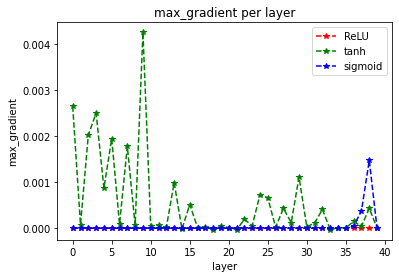

In [ ]:
l = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
  
plt.plot(l, m3a, '*--', color='r', label='ReLU')
plt.plot(l, m3b, '*--', color='g', label='tanh')
plt.plot(l, m3c, '*--', color='b', label='sigmoid')

plt.ylabel("max_gradient")
plt.xlabel("layer")
plt.title("max_gradient per layer")
  
plt.legend()
  
plt.show()

***Observations***

From the graph above, we can observe that the values of the max gradient are close to zero in almost all layers of our models, for both the sigmoid and the ReLu. The only exception is the model where the tanh is used as an activation function.

This also agrees with what we observed back in question 1B, where we saw that model 2b by far outperformed the other 2 models. 


In the case of the sigmoid function, the training process of model 2c did not proceed at all, which is once again caused by the vanishing gradient problem. This is also depicted in the graph above, where we can see the values of the gradient becoming smaller as we move from the output to the input layers of the network.

 
In the case of the ReLU activation, the reason why the gradient is almost zero in all 40 layers is not exactly clear, but this would explain why we observed the training process of model 3a being stack for many epochs, and generally not having a smooth learning curve back in question 1B. 


***References***


https://keras.io/getting_started/intro_to_keras_for_researchers/


https://machinelearningmastery.com/visualizing-the-vanishing-gradient-problem/